In [1]:
### Reloads modules properly
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext lab_black

# Ultimate DBSCAN comparison

We will compare here the results of DBSCAN with the premade binary files.
The comparison will be between SKLEARN DBSCAN and the accelerated DBSCAN

# Setup

In [3]:
storage_path = "/media/lucas/QS/binaries-trk-100/"

# SKLEARN DBSCAN

In [4]:
from sklearn.cluster import DBSCAN

In [5]:
import numpy as np
import pandas as pd

In [6]:
pv_z0 = []
pv_pt = []
pv_mc = []

for i in range(100):
    z0_file = storage_path + f"b-{i}-trk-z0.bin"
    pt_file = storage_path + f"b-{i}-trk-pt.bin"
    mc_file = storage_path + f"b-{i}-trk-mc.bin"

    z0 = np.fromfile(z0_file, dtype=np.float32)
    pt = np.fromfile(pt_file, dtype=np.float32)
    mc = np.fromfile(mc_file, dtype=np.float32)
    pv_mc.append(mc[0])

    df = pd.DataFrame({"z0": z0, "pt": pt})

    db = DBSCAN(eps=0.15, min_samples=2).fit(z0.reshape(-1, 1))

    df["label"] = db.labels_

    noise_mask = df.label == -1
    df_noise_removed = df[~noise_mask].copy()

    clusters = df_noise_removed.groupby(["label"]).agg(
        {"z0": [np.median], "pt": [np.sum]}
    )
    clusters.columns = ["z0_median", "pt_sum"]
    clusters.sort_values(by="pt_sum", ascending=False, inplace=True)

    pv_z0.append(clusters["z0_median"].iloc[0])
    pv_pt.append(clusters["pt_sum"].iloc[0])

In [7]:
skl = pd.DataFrame({"pv_z0": pv_z0, "pt_sum": pv_pt, "pv_mc": pv_mc})

In [8]:
skl

,pv_z0,pt_sum,pv_mc
0,4.980469,84.025032,5.055163
1,-2.226562,142.023392,-3.608661
2,-0.175781,322.723816,-0.261453
3,2.753906,315.833466,2.803285
4,-3.837891,241.590347,-3.764995
...,...,...,...
95,-1.992188,146.755081,-1.949224
96,-0.820312,261.312958,-0.863506
97,1.699219,315.512695,1.698641
98,0.175781,141.515457,0.128382


In [9]:
pv_mask = np.abs(skl["pv_z0"] - skl["pv_mc"]) < 0.15

In [10]:
100 * (pv_mask.sum() / 100)

81.0

This is the efficiency and the results obtained with sklearn

# Results with Accelerated DBSCAN

This have been pre-run by the C++ code

In [11]:
!ls -lhtr /media/lucas/QS/accelerated_results/

total 800K
-rw-rw-r-- 1 lucas lucas  8 Jun 24 14:49 pv-z0-9.txt
-rw-rw-r-- 1 lucas lucas  8 Jun 24 14:49 pv-z0-99.txt
-rw-rw-r-- 1 lucas lucas  9 Jun 24 14:49 pv-z0-98.txt
-rw-rw-r-- 1 lucas lucas  8 Jun 24 14:49 pv-z0-97.txt
-rw-rw-r-- 1 lucas lucas 10 Jun 24 14:49 pv-z0-96.txt
-rw-rw-r-- 1 lucas lucas  9 Jun 24 14:49 pv-z0-95.txt
-rw-rw-r-- 1 lucas lucas  9 Jun 24 14:49 pv-z0-94.txt
-rw-rw-r-- 1 lucas lucas  8 Jun 24 14:49 pv-z0-93.txt
-rw-rw-r-- 1 lucas lucas  9 Jun 24 14:49 pv-z0-92.txt
-rw-rw-r-- 1 lucas lucas  9 Jun 24 14:49 pv-z0-91.txt
-rw-rw-r-- 1 lucas lucas  8 Jun 24 14:49 pv-z0-90.txt
-rw-rw-r-- 1 lucas lucas  9 Jun 24 14:49 pv-z0-8.txt
-rw-rw-r-- 1 lucas lucas  9 Jun 24 14:49 pv-z0-89.txt
-rw-rw-r-- 1 lucas lucas  8 Jun 24 14:49 pv-z0-88.txt
-rw-rw-r-- 1 lucas lucas  8 Jun 24 14:49 pv-z0-87.txt
-rw-rw-r-- 1 lucas lucas  9 Jun 24 14:49 pv-z0-86.txt
-rw-rw-r-- 1 lucas lucas  8 Jun 24 14:49 pv-z0-85.txt
-rw-rw-r-- 1 lucas lucas 10 Jun 24 14:49 pv-z0-84.txt
-rw-rw-r-- 1 lucas 

In [12]:
pv_z0_acc = []
pv_pt_acc = []
storage_acc = "/media/lucas/QS/accelerated_results/"
for i in range(100):
    z0_file = storage_acc + f"pv-z0-{i}.txt"
    pt_file = storage_acc + f"pv-pt-{i}.txt"

    z0 = np.loadtxt(z0_file, dtype=np.float32)
    pt = np.loadtxt(pt_file, dtype=np.float32)

    pv_z0_acc.append(z0)
    pv_pt_acc.append(pt)

In [13]:
acc = pd.DataFrame({"pv_z0": pv_z0_acc, "pt_sum": pv_pt_acc, "pv_mc": pv_mc})

In [14]:
acc

,pv_z0,pt_sum,pv_mc
0,4.98047,84.2682,5.055163
1,-2.22656,142.435,-3.608661
2,-0.175781,323.658,-0.261453
3,2.75391,316.748,2.803285
4,-3.80859,242.29,-3.764995
...,...,...,...
95,-1.99219,147.18,-1.949224
96,-0.820312,262.069,-0.863506
97,1.69922,316.426,1.698641
98,0.175781,141.925,0.128382


In [15]:
mask_acc = np.abs(acc["pv_z0"] - acc["pv_mc"]) < 0.15

In [16]:
100 * mask_acc.sum() / 100

80.0

These are the results with the accelerated DBSCAN

# Accelerated DBSCAN (Python)

In [17]:
storage_path

'/media/lucas/QS/binaries-trk-100/'

In [18]:
pv_z0_py = []
pv_pt_py = []

max_number_of_tracks = 232
eps = 0.15
from acceleratedDBSCAN import AccDBSCAN

for i in range(100):
    z0_file = storage_path + f"b-{i}-trk-z0.bin"
    pt_file = storage_path + f"b-{i}-trk-pt.bin"

    z0 = np.fromfile(z0_file, dtype=np.float32)
    pt = np.fromfile(pt_file, dtype=np.float32)

    df = pd.DataFrame({"z0": z0, "pt": pt})

    _db = AccDBSCAN(z0, pt, eps, max_number_of_tracks, False)
    _db.fit()

    pv_z0_py.append(_db.pv_z0)
    pv_pt_py.append(_db.pv_pt)

In [21]:
pass_py = np.abs(pv_z0_py - np.array(pv_mc)) < 0.15

In [22]:
pv_z0_py2 = []
pv_pt_py2 = []

max_number_of_tracks = 232
eps = 0.15
from acceleratedDBSCAN import AccDBSCAN

for i in range(100):
    z0_file = storage_path + f"b-{i}-trk-z0.bin"
    pt_file = storage_path + f"b-{i}-trk-pt.bin"

    z0 = np.fromfile(z0_file, dtype=np.float32)
    pt = np.fromfile(pt_file, dtype=np.float32)

    df = pd.DataFrame({"z0": z0, "pt": pt})

    _db = AccDBSCAN(z0, pt, eps, max_number_of_tracks, False)
    _db.fit()

    pv_z0_py2.append(_db.pv_z0)
    pv_pt_py2.append(_db.pv_pt)

In [26]:
pv_z0_py2

[2.4609375,
 -2.2265625,
 -0.17578125,
 2.75390625,
 -3.80859375,
 -0.41015625,
 1.5234375,
 1.640625,
 0.8203125,
 1.11328125,
 -3.3984375,
 3.3984375,
 -4.39453125,
 3.10546875,
 -0.99609375,
 1.58203125,
 -3.8671875,
 -4.98046875,
 -0.234375,
 0.9375,
 -0.64453125,
 -3.75,
 3.22265625,
 -1.171875,
 1.69921875,
 -1.2890625,
 -1.11328125,
 1.40625,
 0.0,
 -0.1171875,
 0.87890625,
 4.98046875,
 -3.57421875,
 -0.05859375,
 2.75390625,
 -5.390625,
 1.23046875,
 -2.63671875,
 0.05859375,
 4.98046875,
 -0.1171875,
 -2.63671875,
 -3.8671875,
 -2.98828125,
 -0.8203125,
 -0.29296875,
 -4.39453125,
 0.0,
 1.11328125,
 0.29296875,
 -1.2890625,
 0.0,
 2.28515625,
 -0.5859375,
 -5.80078125,
 0.703125,
 0.05859375,
 -2.28515625,
 -5.91796875,
 -2.2265625,
 -0.9375,
 1.58203125,
 2.05078125,
 -0.41015625,
 -0.05859375,
 -1.34765625,
 -3.45703125,
 -1.40625,
 3.984375,
 4.39453125,
 4.27734375,
 2.4609375,
 -6.4453125,
 4.6875,
 2.75390625,
 0.64453125,
 4.62890625,
 5.09765625,
 -0.3515625,
 -3.457

# Analyzing results

In [28]:
results = pd.DataFrame({})

In [29]:
results

""


In [30]:
results["pv_mc"] = skl["pv_mc"]
results["skl_z0"] = skl["pv_z0"]
results["acc_z0"] = acc["pv_z0"]
results["py_z0"] = pv_z0_py
results["skl_pt"] = skl["pt_sum"]
results["acc_pt"] = acc["pt_sum"]
results["py_pt"] = pv_z0_py
results["passed_skl"] = pv_mask
results["passed_acc"] = mask_acc
results["passed_py"] = pass_py

In [31]:
results["py2_z0"] = pv_z0_py2
results["py2_pt"] = pv_pt_py2

In [32]:
results

,pv_mc,skl_z0,acc_z0,py_z0,skl_pt,acc_pt,py_pt,passed_skl,passed_acc,passed_py,py2_z0,py2_pt
0,5.055163,4.980469,4.98047,2.460938,84.025032,84.2682,2.460938,True,True,False,2.460938,85.212932
1,-3.608661,-2.226562,-2.22656,-2.226562,142.023392,142.435,-2.226562,False,False,False,-2.226562,125.927683
2,-0.261453,-0.175781,-0.175781,-0.175781,322.723816,323.658,-0.175781,True,True,True,-0.175781,233.015672
3,2.803285,2.753906,2.75391,2.753906,315.833466,316.748,2.753906,True,True,True,2.753906,117.907624
4,-3.764995,-3.837891,-3.80859,-3.837891,241.590347,242.29,-3.837891,True,True,True,-3.808594,137.325767
...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.949224,-1.992188,-1.99219,-1.992188,146.755081,147.18,-1.992188,True,True,True,-1.992188,83.840155
96,-0.863506,-0.820312,-0.820312,-0.820312,261.312958,262.069,-0.820312,True,True,True,-0.820312,173.664954
97,1.698641,1.699219,1.69922,1.699219,315.512695,316.426,1.699219,True,True,True,1.699219,236.707262
98,0.128382,0.175781,0.175781,1.523438,141.515457,141.925,1.523438,True,True,False,1.523438,136.140112


In [33]:
pd.set_option("display.max_rows", None)

In [34]:
results["z0_diff"] = results["skl_z0"] - results["acc_z0"]
results["pt_diff"] = results["skl_pt"] - results["acc_pt"]

In [35]:
results["pt_p_diff"] = 100 * (results["pt_diff"]) / results["skl_pt"]

In [36]:
results["pt_p_diff"]

0    -0.289404
1    -0.289816
2    -0.289465
3    -0.289558
4      -0.2896
5    -0.289525
6    -0.289465
7    -0.289431
8      -0.2896
9    -0.289543
10   -0.289558
11   -0.289569
12   -0.289457
13   -0.289524
14   -0.289656
15   -0.289457
16   -0.289453
17   -0.289154
18   -0.289716
19   -0.289542
20   -0.289725
21   -0.289759
22   -0.289438
23   -0.289355
24    -0.28928
25   -0.289375
26    -0.28954
27   -0.289399
28   -0.289624
29   -0.289389
30   -0.289498
31   -0.289469
32   -0.289417
33   -0.289509
34   -0.289436
35   -0.289324
36   -0.289535
37   -0.289806
38   -0.289407
39   -0.289448
40   -0.289197
41   -0.289511
42   -0.289357
43   -0.289442
44   -0.289332
45   -0.289388
46    -0.28959
47    -0.28965
48   -0.289502
49   -0.289354
50   -0.289468
51   -0.289605
52   -0.289487
53   -0.289313
54   -0.289476
55   -0.289387
56   -0.289484
57   -0.289482
58   -0.289393
59   -0.289528
60   -0.289361
61   -0.289555
62   -0.289232
63    -0.28955
64   -0.289412
65   -0.289422
66    -0.2

<AxesSubplot:>

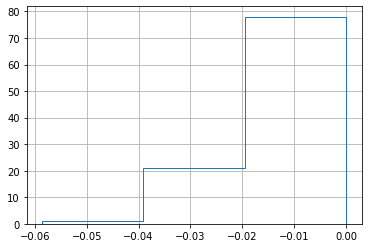

In [37]:
results["z0_diff"].hist(bins=3, histtype="step")

In [38]:
results["z0_p_diff"]

KeyError: 'z0_p_diff'

In [ ]:
results

In [ ]:
results.head()

In [41]:
results[["pv_mc", "skl_z0", "acc_z0", "py_z0", "py2_z0"]]

,pv_mc,skl_z0,acc_z0,py_z0,py2_z0
0,5.055163,4.980469,4.98047,2.460938,2.460938
1,-3.608661,-2.226562,-2.22656,-2.226562,-2.226562
2,-0.261453,-0.175781,-0.175781,-0.175781,-0.175781
3,2.803285,2.753906,2.75391,2.753906,2.753906
4,-3.764995,-3.837891,-3.80859,-3.837891,-3.808594
5,-0.675341,-0.410156,-0.410156,-0.410156,-0.410156
6,-5.478010,-5.449219,-5.44922,1.523438,1.523438
7,1.570426,1.640625,1.64062,1.640625,1.640625
8,-3.019287,-3.017578,-2.98828,0.820312,0.820312
9,8.991512,9.023438,9.02344,1.113281,1.113281


# Cumsum pt analysis

In [64]:
pv_z0_acc_cumsum = []
pv_pt_acc_cumsum = []
storage_acc = "/media/lucas/QS/accelerated_results_cumsum/"
for i in range(100):
    z0_file = storage_acc + f"pv-z0-{i}.txt"
    pt_file = storage_acc + f"pv-pt-{i}.txt"

    z0 = np.loadtxt(z0_file, dtype=np.float32)
    pt = np.loadtxt(pt_file, dtype=np.float32)

    pv_z0_acc_cumsum.append(z0)
    pv_pt_acc_cumsum.append(pt)

In [66]:
cumsum = pd.DataFrame({"pv_z0": pv_z0_acc_cumsum, "pt_sum": pv_pt_acc_cumsum})

In [68]:
results["pt_cumsum"] = cumsum["pt_sum"]

In [71]:
results["pt_diff_cs"] = results["skl_pt"] - results["pt_cumsum"]

In [72]:
results

,pv_mc,skl_z0,acc_z0,skl_pt,acc_pt,passed_skl,passed_acc,z0_diff,z0_p_diff,pt_diff,pt_p_diff,pt_cumsum,pt_diff_cs
0,5.055163,4.980469,4.98047,84.025032,84.2682,True,True,-0.000001,-0.000028,-0.243172,-0.289404,85.1664,-1.141365
1,-3.608661,-2.226562,-2.22656,142.023392,142.435,False,False,-0.000002,0.000066,-0.411606,-0.289816,141.403,0.620392
2,-0.261453,-0.175781,-0.175781,322.723816,323.658,True,True,-0.0,0.000097,-0.934174,-0.289465,323.355,-0.631195
3,2.803285,2.753906,2.75391,315.833466,316.748,True,True,-0.000004,-0.000136,-0.91452,-0.289558,307.678,8.155457
4,-3.764995,-3.837891,-3.80859,241.590347,242.29,True,True,-0.029301,0.77824,-0.699646,-0.2896,242.651,-1.060654
5,-0.675341,-0.410156,-0.410156,335.896484,336.869,False,False,-0.0,0.000035,-0.972504,-0.289525,337.087,-1.190521
6,-5.478010,-5.449219,-5.44922,207.244095,207.844,True,True,0.000001,-0.000026,-0.599899,-0.289465,202.65,4.594101
7,1.570426,1.640625,1.64062,213.209900,213.827,True,True,0.000005,0.000319,-0.617096,-0.289431,204.244,8.965897
8,-3.019287,-3.017578,-2.98828,181.920166,182.447,True,True,-0.029298,0.970364,-0.52684,-0.2896,181.898,0.022171
9,8.991512,9.023438,9.02344,89.547226,89.8065,True,True,-0.000003,-0.000032,-0.259277,-0.289543,88.362,1.185226


# Analysis between C++ and Python

### Running Acc DBSCAN (Python) with debug on

In [115]:
from acceleratedDBSCAN import AccDBSCAN

In [116]:
storage_path

'/media/lucas/QS/binaries-trk-100/'

In [117]:
max_number_of_tracks = 232
eps = 0.15
z0_file = storage_path + "b-0-trk-z0.bin"
pt_file = storage_path + "b-0-trk-pt.bin"
z0 = np.fromfile(z0_file, dtype=np.float32)
pt = np.fromfile(pt_file, dtype=np.float32)

_db = AccDBSCAN(z0, pt, eps, max_number_of_tracks, False, True)
_db.fit()

In [118]:
!ls -lhtr

total 22M
-rwxr-xr-x 1 lucas lucas 252K Jan 24 14:03  TracksPerPhiSector.png
-rwxr-xr-x 1 lucas lucas 376K Jan 24 14:03  TrackParameters.png
-rwxr-xr-x 1 lucas lucas 108K Jan 24 14:03  residuals.png
-rwxr-xr-x 1 lucas lucas 6.8K Jan 24 14:03  README.md
-rwxr-xr-x 1 lucas lucas 637K Jan 24 14:03  L1TriggerInputData.png
-rwxr-xr-x 1 lucas lucas 3.2K Jan 24 14:03  histograms.py
-rwxr-xr-x 1 lucas lucas 8.9K Jan 24 14:03  analysis.py
-rwxr-xr-x 1 lucas lucas  954 Jan 24 14:03  fasthisto_optimization.py
-rwxr-xr-x 1 lucas lucas 1.7K Jan 24 14:03  dbscan_optimization.py
-rwxr-xr-x 1 lucas lucas  921 Jan 24 14:03  convert_root_to_pickle.py
-rwxr-xr-x 1 lucas lucas 2.2K Jan 24 14:03  checkFastHisto.py
-rwxr-xr-x 1 lucas lucas 5.1K Jan 24 14:03  analyze_files.py
drwxr-xr-x 2 lucas lucas 4.0K Jan 24 14:03  plots
-rwxr-xr-x 1 lucas lucas  16K Mar 28 16:56  analyze_hdbscan.py
-rwxr-xr-x 1 lucas lucas  11K Apr 29 16:24  clusters.npy
-rw-rw-r-- 1 lucas lucas 2.5K May  3 13:35  boundaries.npy
-rw-rw-

In [119]:
input_tracks_py = pd.read_csv("input_tracks.csv")
input_tracks_py.drop(columns=["Unnamed: 0"], inplace=True)

In [120]:
rs_py = pd.read_csv("rs.csv")
rs_py.drop(columns=["Unnamed: 0"], inplace=True)
rs_py.columns = ["pt_sum"]

In [127]:
rs_py2 = pd.read_csv("rs2.csv")
rs_py2.drop(columns=["Unnamed: 0"], inplace=True)
rs_py2.columns = ["pt_sum"]

In [128]:
rs_py2.head()

,pt_sum
0,2.623967
1,6.058993
2,9.833901
3,12.475349
4,14.796002


In [121]:
rs_py.head()

,pt_sum
0,0.000000
1,2.623967
2,6.058993
3,9.833901
4,12.475349


In [122]:
left_boundaries_py = pd.read_csv("left_boundaries.csv")
left_boundaries_py.drop(columns=["Unnamed: 0"], inplace=True)

In [123]:
boundaries_py = pd.read_csv("boundaries.csv")
boundaries_py.drop(columns=["Unnamed: 0"], inplace=True)

In [124]:
vertices_py = pd.read_csv("vertices.csv")
vertices_py.drop(columns=["Unnamed: 0"], inplace=True)

### Loading the Acc DBSCAN (C++) with outputs

In [42]:
!ls -lhtr /media/lucas/QS/accelerated_results_file0/

total 28K
-rw-rw-r-- 1 lucas lucas 3.7K Jun 27 13:39 input_tracks.csv
-rw-rw-r-- 1 lucas lucas 1.9K Jun 27 13:39 rs.csv
-rw-rw-r-- 1 lucas lucas  464 Jun 27 13:39 left_boundaries.csv
-rw-rw-r-- 1 lucas lucas  934 Jun 27 13:39 vertices.csv
-rw-rw-r-- 1 lucas lucas    8 Jun 27 13:39 pv-z0-0.txt
-rw-rw-r-- 1 lucas lucas 2.8K Jun 27 13:39 boundaries.csv
-rw-rw-r-- 1 lucas lucas    8 Jun 27 13:39 pv-pt-0.txt


In [43]:
storage1 = "/media/lucas/QS/accelerated_results_file0/"

In [44]:
input_tracks = pd.read_csv(storage1 + "input_tracks.csv")

In [48]:
input_tracks.columns = ["z0", "oneOverR"]

In [49]:
input_tracks["pt"] = 0.3 * 3.811 / (input_tracks["oneOverR"] * 100)

In [51]:
input_tracks.head()

,z0,oneOverR,pt
0,-0.878906,0.004345,2.631561
1,3.339840,0.003319,3.444972
2,4.921880,0.003020,3.785837
3,-0.468750,0.004316,2.649097
4,4.980470,0.004912,2.327371


In [52]:
rs = pd.read_csv(storage1 + "rs.csv")

In [56]:
left_boundaries = pd.read_csv(storage1 + "left_boundaries.csv", names=["bound"])

In [62]:
left_boundaries

,bound
0,1
1,0
2,1
3,1
4,0
5,1
6,0
7,0
8,0
9,0


In [58]:
boundaries = pd.read_csv(storage1 + "boundaries.csv")

In [59]:
boundaries.head()

,idx,pts,nextPts
0,0,0.00000,2.58093
1,1,2.58093,4.73621
2,232,0.00000,0.00000
3,3,8.04109,11.34600
4,4,11.34600,14.66560


In [60]:
vertices = pd.read_csv(storage1 + "vertices.csv")

In [61]:
vertices

,z0,pt_sum
0,4.980470,84.268200
1,2.460940,55.702200
2,-1.875000,49.184500
3,-1.054690,43.954800
4,-3.046880,37.484400
5,-0.468750,27.280000
6,-3.632810,24.782700
7,5.683590,24.051600
8,-5.039060,21.456600
9,-4.160160,12.080700


## Comparison

### input track comparison

In [93]:
input_tracks.sort_values(by="z0", inplace=True)

In [92]:
input_tracks_py.sort_values(by="z0", inplace=True)

In [98]:
c1 = pd.DataFrame({})
c1["z0cpp"] = input_tracks["z0"]
c1["z0py"] = input_tracks["z0"]
c1["ptcpp"] = input_tracks["pt"]
c1["ptpy"] = input_tracks["pt"]
c1["z0_diff"] = c1["z0cpp"] - c1["z0py"]
c1["pt_diff"] = c1["ptcpp"] - c1["ptpy"]

In [101]:
c1.loc[c1.z0cpp < 21][["z0_diff", "pt_diff"]].sum()

z0_diff    0.0
pt_diff    0.0
dtype: float64

looks good!

### rs comparison

In [113]:
c2 = pd.DataFrame({})
c2["rscpp"] = rs["pt_sum"]
c2["rspy"] = rs_py["pt_sum"]
c2["rsdiff"] = c2["rscpp"] - c2["rspy"]

In [130]:
c2.shape

(256, 3)

In [131]:
c2["rspy2"] = rs_py2

In [134]:
c2["rspy2"] = c2["rspy2"].shift()

In [137]:
c2["rspy2"][0] = 0

In [139]:
c2["rspydiff"] = c2["rspy"] - c2["rspy2"]

In [140]:
c2

,rscpp,rspy,rsdiff,rspy2,rspydiff
0,0.00000,0.000000,0.000000,0.000000,0.0
1,2.58093,2.623967,-0.043037,2.623967,0.0
2,4.73621,6.058993,-1.322783,6.058993,0.0
3,8.04109,9.833901,-1.792811,9.833901,0.0
4,11.34600,12.475349,-1.129349,12.475349,0.0
5,14.66560,14.796002,-0.130402,14.796002,0.0
6,16.92410,17.531160,-0.607060,17.531160,0.0
7,19.23980,19.850359,-0.610559,19.850359,0.0
8,21.26050,22.760452,-1.499952,22.760452,0.0
9,24.37410,28.462560,-4.088460,28.462560,0.0


its very strange theres such a difference in pt sum from the prefix sum!

### left boundaries

In [146]:
c3 = pd.DataFrame({})
c3["bcpp"] = left_boundaries["bound"]
c3["bpy"] = left_boundaries_py["bound"]
c3["bpy"] = c3["bpy"].astype(int)

In [149]:
c3["b_diff"] = c3["bcpp"] - c3["bpy"]

In [151]:
c3["b_diff"].sum()

0

left boundaries are good!

### boundaries

In [155]:
c4 = pd.concat([boundaries, boundaries_py], axis=1)

In [157]:
c4["diff_idx"] = c4.iloc[:, 0] - c4.iloc[:, 3]

In [159]:
c4["diff_idx"].sum()

0.0

In [160]:
c4.head()

,idx,pts,nextPts,idx,pts,nextPts,diff,z0_min,z0_max,diff_idx
0,0,0.00000,2.58093,0.0,0.000000,2.623967,2.623967,-7.441406,-7.441406,0.0
1,1,2.58093,4.73621,1.0,2.623967,6.058993,3.435026,-7.441406,-6.972656,0.0
2,232,0.00000,0.00000,232.0,0.000000,0.000000,0.000000,21.000000,21.000000,0.0
3,3,8.04109,11.34600,3.0,9.833901,12.475349,2.641448,-6.562500,-6.503906,0.0
4,4,11.34600,14.66560,4.0,12.475349,14.796002,2.320653,-6.503906,-6.328125,0.0


In [162]:
c4.columns = [
    "idx_cpp",
    "pts_cpp",
    "nextPts_cpp",
    "idx_py",
    "pts_py",
    "nextPts_py",
    "diff",
    "z0_min",
    "z0_max",
    "diff_idx",
]

In [163]:
c5 = c4.sort_values(by="idx_cpp")

In [164]:
c5

,idx_cpp,pts_cpp,nextPts_cpp,idx_py,pts_py,nextPts_py,diff,z0_min,z0_max,diff_idx
0,0,0.00000,2.58093,0.0,0.000000,2.623967,2.623967,-7.441406,-7.441406,0.0
1,1,2.58093,4.73621,1.0,2.623967,6.058993,3.435026,-7.441406,-6.972656,0.0
3,3,8.04109,11.34600,3.0,9.833901,12.475349,2.641448,-6.562500,-6.503906,0.0
4,4,11.34600,14.66560,4.0,12.475349,14.796002,2.320653,-6.503906,-6.328125,0.0
5,5,14.66560,16.92410,5.0,14.796002,17.531160,2.735158,-6.328125,-6.328125,0.0
9,9,24.37410,26.35990,9.0,28.462560,31.663831,3.201270,-6.035156,-5.332031,0.0
10,10,26.35990,31.24540,10.0,31.663831,34.415939,2.752108,-5.332031,-5.214844,0.0
16,16,45.85110,47.81650,16.0,48.504388,50.581859,2.077471,-4.863281,-4.453125,0.0
18,18,50.12600,52.84170,18.0,53.887011,59.432467,5.545457,-4.218750,-4.160156,0.0
22,22,59.97090,62.20670,22.0,70.894160,73.998747,3.104588,-4.042969,-3.808594,0.0


In [173]:
pt_sum_cpp = []
pt_sum_py = []
for i in range(0, 232, 2):
    _pt_cpp = c5.iloc[i + 1, 2] - c5.iloc[i, 1]
    pt_sum_cpp.append(_pt_cpp)
    _pt_py = c5.iloc[i + 1, 5] - c5.iloc[i, 4]
    pt_sum_py.append(_pt_py)

In [175]:
pt_clusters = pd.DataFrame({})
pt_clusters["pt_cpp"] = pt_sum_cpp
pt_clusters["pt_py"] = pt_sum_py

In [176]:
pt_clusters

,pt_cpp,pt_py
0,4.73621,6.058993
1,6.62451,4.962101
2,11.69430,16.867828
3,21.45660,18.918028
4,12.08070,20.111737
5,24.78270,27.173762
6,37.48460,39.735436
7,7.80700,9.222648
8,49.18500,49.981936
9,43.95500,48.861444


So. yea the pt estimates are completely off, what the fuck is going on?

### vertices comparison

In [179]:
vertices_py.columns = ["z0_py", "pt_sum_py"]

In [181]:
c6 = pd.concat([vertices, vertices_py], axis=1)

In [190]:
vertices.columns = ["z0", "pt_sum"]

In [197]:
c7 = pd.DataFrame({})
c7["z0_cpp"] = vertices.sort_values(by=["z0"]).z0
c7["z0_py"] = vertices_py.sort_values(by=["z0_py"]).z0_py
c7["pt_cpp"] = vertices.sort_values(by=["z0"]).pt_sum
c7["pt_py"] = vertices_py.sort_values(by=["z0_py"]).pt_sum_py

In [199]:
vertices.sort_values(by="z0", inplace=True)

In [200]:
vertices_py.sort_values(by="z0_py", inplace=True)

In [205]:
z0_cpp = vertices.z0.values
pt_cpp = vertices.pt_sum.values
z0_py = vertices_py.z0_py.values
pt_py = vertices_py.pt_sum_py.values
c8 = pd.DataFrame({})
c8["z0_cpp"] = z0_cpp
c8["z0_py"] = z0_py
c8["pt_cpp"] = pt_cpp
c8["pt_py"] = pt_py

In [206]:
c8

,z0_cpp,z0_py,pt_cpp,pt_py
0,-7.441410,-7.441406,4.736210,6.058993
1,-6.503910,-6.533203,6.624540,4.962101
2,-6.269530,-6.269531,11.694200,16.867828
3,-5.039060,-5.039062,21.456600,18.918028
4,-4.160160,-4.160156,12.080700,20.111737
5,-3.632810,-3.662109,24.782700,27.173762
6,-3.046880,-3.046875,37.484400,39.735436
7,-2.460940,-2.460938,7.807710,9.222648
8,-1.875000,-1.875000,49.184500,49.981936
9,-1.054690,-1.054688,43.954800,48.861444


In [204]:
vertices_py.head()

,z0_py,pt_sum_py
13,-7.441406,6.058993
15,-6.533203,4.962101
10,-6.269531,16.867828
9,-5.039062,18.918028
8,-4.160156,20.111737


In [191]:
vertices["pt_sum"]

0      84.268200
1      55.702200
2      49.184500
3      43.954800
4      37.484400
5      27.280000
6      24.782700
7      24.051600
8      21.456600
9      12.080700
10     11.694200
11      9.554170
12      7.807710
13      6.624540
14      6.313690
15      5.623990
16      5.048250
17      4.736210
18      4.326030
19      0.000000
20      0.000000
21      0.000000
22      0.000000
23      0.000000
24      0.000000
25      0.000000
26      0.000000
27      0.000000
28      0.000000
29      0.000000
30      0.000000
31      0.000000
32      0.000000
33      0.000000
34      0.000000
35      0.000000
36      0.000000
37      0.000000
38      0.000000
39      0.000000
40      0.000000
41      0.000000
42      0.000000
43      0.000000
44      0.000000
45      0.000000
46      0.000000
47      0.000000
48      0.000000
49      0.000000
50      0.000000
51      0.000000
52      0.000000
53      0.000000
54      0.000000
55      0.000000
56      0.000000
57      0.000000
58      0.0000

In [202]:
pd.concat([vertices, vertices_py], axis=1)

,z0,pt_sum,z0_py,pt_sum_py
17,-7.441410,4.736210,4.189453,4.467612
13,-6.503910,6.624540,-7.441406,6.058993
10,-6.269530,11.694200,-6.269531,16.867828
8,-5.039060,21.456600,-4.160156,20.111737
9,-4.160160,12.080700,-5.039062,18.918028
6,-3.632810,24.782700,-0.468750,24.605893
4,-3.046880,37.484400,-3.046875,39.735436
12,-2.460940,7.807710,3.222656,8.755157
2,-1.875000,49.184500,-1.054688,48.861444
3,-1.054690,43.954800,4.980469,42.113034


In [196]:
vertices.sort_values(by="z0")

,z0,pt_sum
17,-7.441410,4.736210
13,-6.503910,6.624540
10,-6.269530,11.694200
8,-5.039060,21.456600
9,-4.160160,12.080700
6,-3.632810,24.782700
4,-3.046880,37.484400
12,-2.460940,7.807710
2,-1.875000,49.184500
3,-1.054690,43.954800


In [183]:
mask = c6.z0 < 21
c6[mask]

,z0,pt_sum,z0_py,pt_sum_py
0,4.980470,84.26820,2.460938,85.212932
1,2.460940,55.70220,-1.875000,49.981936
2,-1.875000,49.18450,-1.054688,48.861444
3,-1.054690,43.95480,4.980469,42.113034
4,-3.046880,37.48440,-3.046875,39.735436
5,-0.468750,27.28000,-3.662109,27.173762
6,-3.632810,24.78270,-0.468750,24.605893
7,5.683590,24.05160,5.654297,20.596686
8,-5.039060,21.45660,-4.160156,20.111737
9,-4.160160,12.08070,-5.039062,18.918028


### Runinng the fixed Accelerated DBSCAN (python)

In [207]:
pv_z0_py_fx = []
pv_pt_py_fx = []

max_number_of_tracks = 232
eps = 0.15
from acceleratedDBSCAN import AccDBSCAN

for i in range(100):
    z0_file = storage_path + f"b-{i}-trk-z0.bin"
    pt_file = storage_path + f"b-{i}-trk-pt.bin"

    z0 = np.fromfile(z0_file, dtype=np.float32)
    pt = np.fromfile(pt_file, dtype=np.float32)

    df = pd.DataFrame({"z0": z0, "pt": pt})

    _db = AccDBSCAN(z0, pt, eps, max_number_of_tracks, False)
    _db.fit()

    pv_z0_py_fx.append(_db.pv_z0)
    pv_pt_py_fx.append(_db.pv_pt)

In [209]:
results["pyfx_z0"] = pv_z0_py_fx
results["pyfx_pt"] = pv_pt_py_fx

In [210]:
results.columns

Index(['pv_mc', 'skl_z0', 'acc_z0', 'py_z0', 'skl_pt', 'acc_pt', 'py_pt',
       'passed_skl', 'passed_acc', 'passed_py', 'py2_z0', 'py2_pt', 'z0_diff',
       'pt_diff', 'pt_p_diff', 'pyfx_z0', 'pyfx_pt'],
      dtype='object')

In [211]:
results[["pv_mc", "skl_z0", "acc_z0", "py_z0", "pyfx_z0"]]

,pv_mc,skl_z0,acc_z0,py_z0,pyfx_z0
0,5.055163,4.980469,4.98047,2.460938,4.980469
1,-3.608661,-2.226562,-2.22656,-2.226562,-2.226562
2,-0.261453,-0.175781,-0.175781,-0.175781,-0.175781
3,2.803285,2.753906,2.75391,2.753906,2.753906
4,-3.764995,-3.837891,-3.80859,-3.837891,-3.837891
5,-0.675341,-0.410156,-0.410156,-0.410156,-0.410156
6,-5.478010,-5.449219,-5.44922,1.523438,-5.449219
7,1.570426,1.640625,1.64062,1.640625,1.640625
8,-3.019287,-3.017578,-2.98828,0.820312,-3.017578
9,8.991512,9.023438,9.02344,1.113281,9.023438


In [213]:
np.abs(results["skl_z0"] - results["pyfx_z0"]).sum()

0.0

In [214]:
np.abs(results["skl_pt"] - results["pyfx_pt"]).sum()

0.0005511045455932617

This means that the accelerated DBSCAN python implementation has been fixed!